In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from crypto_volatility_lab.modeling import LSTMGRUPipeline

In [2]:
currency_list = ['BTC-USD', 'ETH-USD', 'LTC-USD']
test_start_date = datetime.strptime('2024-01-01', "%Y-%m-%d")

# Récupération des données

In [3]:
crypto_scraper = CryptoScraper()

In [4]:
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')
ethereum_data = crypto_scraper.get_data_for_currency('ETH-USD')
litecoin_data = crypto_scraper.get_data_for_currency('LTC-USD')

# Création des time series

In [5]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
bitcoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
bitcoin_data["Volatility"] = ts_creator.create_volatility_time_series()

ts_creator = TimeSeriesCreator(data=ethereum_data, date_column_name='Date', value_column_name='Close')
ethereum_data["Log Returns"] = ts_creator.create_log_return_time_series()
ethereum_data["Volatility"] = ts_creator.create_volatility_time_series()

ts_creator = TimeSeriesCreator(data=litecoin_data, date_column_name='Date', value_column_name='Close')
litecoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
litecoin_data["Volatility"] = ts_creator.create_volatility_time_series()

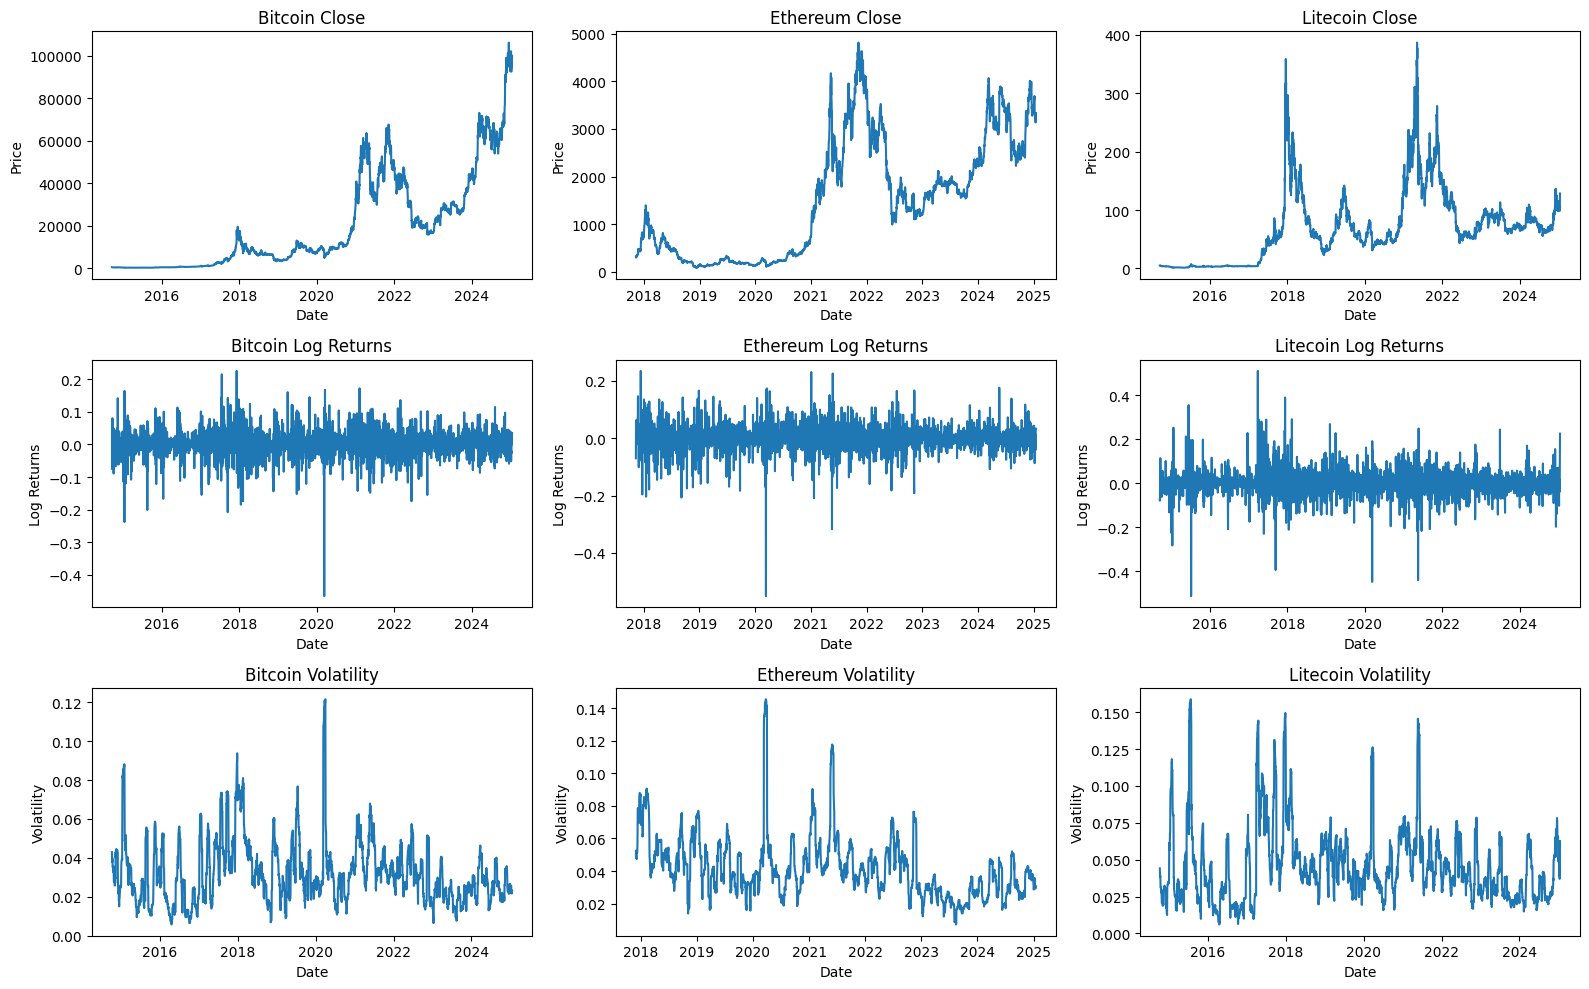

In [6]:
cryptos = [
    ("Bitcoin", bitcoin_data),
    ("Ethereum", ethereum_data),
    ("Litecoin", litecoin_data),
]

metrics = [
    ("Close", "Price"),
    ("Log Returns", "Log Returns"),
    ("Volatility", "Volatility"),
]

fig, ax = plt.subplots(len(metrics), len(cryptos), figsize=(16, 10))

for col, (crypto_name, crypto_data) in enumerate(cryptos):
    for row, (metric, ylabel) in enumerate(metrics):
        ax[row, col].plot(crypto_data["Date"], crypto_data[metric])
        ax[row, col].set_title(f"{crypto_name} {metric}")
        ax[row, col].set_xlabel("Date")
        ax[row, col].set_ylabel(ylabel)

plt.tight_layout()
plt.show()


## Feature engineering

## Train/test split

In [7]:
bitcoin_data.dropna(inplace=True)
ethereum_data.dropna(inplace=True)
litecoin_data.dropna(inplace=True)

In [ ]:
bitcoin_train_data = bitcoin_data[bitcoin_data['Date'] < test_start_date]
bitcoin_test_data = bitcoin_data[bitcoin_data['Date'] >= test_start_date]

ethereum_train_data = ethereum_data[ethereum_data['Date'] < test_start_date]
ethereum_test_data = ethereum_data[ethereum_data['Date'] >= test_start_date]

litecoin_train_data = litecoin_data[litecoin_data['Date'] < test_start_date]
litecoin_test_data = litecoin_data[litecoin_data['Date'] >= test_start_date]

# check proportion of test data
print(f"Bitcoin test data proportion: {round(len(bitcoin_test_data) / len(bitcoin_data)*100, 2)}%")
print(f"Ethereum test data proportion: {round(len(ethereum_test_data) / len(ethereum_data)*100, 2)}%")
print(f"Litecoin test data proportion: {round(len(litecoin_test_data) / len(litecoin_data)*100, 2)}%")

Bitcoin test data proportion: 10.15%
Ethereum test data proportion: 14.63%
Litecoin test data proportion: 10.15%


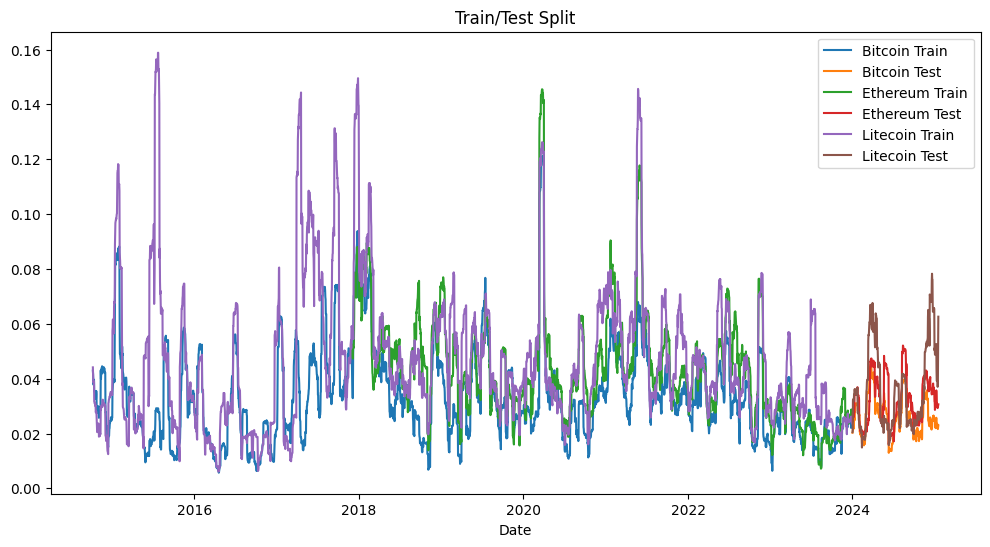

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bitcoin_train_data["Date"], bitcoin_train_data["Volatility"], label="Bitcoin Train")
ax.plot(bitcoin_test_data["Date"], bitcoin_test_data["Volatility"], label="Bitcoin Test")
ax.plot(ethereum_train_data["Date"], ethereum_train_data["Volatility"], label="Ethereum Train")
ax.plot(ethereum_test_data["Date"], ethereum_test_data["Volatility"], label="Ethereum Test")
ax.plot(litecoin_train_data["Date"], litecoin_train_data["Volatility"], label="Litecoin Train")
ax.plot(litecoin_test_data["Date"], litecoin_test_data["Volatility"], label="Litecoin Test")
ax.set_title("Train/Test Split")
ax.set_xlabel("Date")
ax.legend()
plt.show()
# à améliorer

# Prédiction de la volatilité

In [ ]:
# bitcoin model
bitcoin_pipeline = LSTMGRUPipeline(forecast_horizon=1, epochs=30, batch_size=32, validation_split=0.1, normalize=True)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[["Volatility"]].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

# ethereum model
ethereum_pipeline = LSTMGRUPipeline(forecast_horizon=1, epochs=20, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[["Volatility"]].values, ethereum_train_data["Volatility"].values.astype(np.float64))

# litecoin model
litecoin_pipeline = LSTMGRUPipeline(forecast_horizon=1, epochs=30, batch_size=32, validation_split=0.1, normalize=True)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[["Volatility"]].values, litecoin_train_data["Volatility"].values.astype(np.float64))

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0192 - val_loss: 5.9295e-04
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0033 - val_loss: 5.7729e-04
Epoch 3/30


In [11]:
# Evaluation
print("Bitcoin")
print("Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[["Volatility"]].values, bitcoin_train_data["Volatility"].values.astype(np.float64))
print("Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[["Volatility"]].values, bitcoin_test_data["Volatility"].values.astype(np.float64))

print("Ethereum")
print("Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[["Volatility"]].values, ethereum_train_data["Volatility"].values.astype(np.float64))
print("Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[["Volatility"]].values, ethereum_test_data["Volatility"].values.astype(np.float64))

print("Litecoin")
print("Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[["Volatility"]].values, litecoin_train_data["Volatility"].values.astype(np.float64))
print("Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[["Volatility"]].values, litecoin_test_data["Volatility"].values.astype(np.float64))

Bitcoin
Train
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0029
Mean Absolute Percentage Error (MAPE): 11.3688%
Test
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0020
Mean Absolute Percentage Error (MAPE): 7.6566%
Ethereum
Train
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0048
Mean Absolute Percentage Error (MAPE): 11.9756%
Test
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0040
Mean Absolute Percentage Error (MAPE): 12.8755%
Litecoin
Train
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0043
Mean Absolute Percentage Error (MAPE): 12.8772%
Test
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0030
Mean Absolute Percentage Error (MAPE): 9.1481%


TypeError: 'History' object is not subscriptable

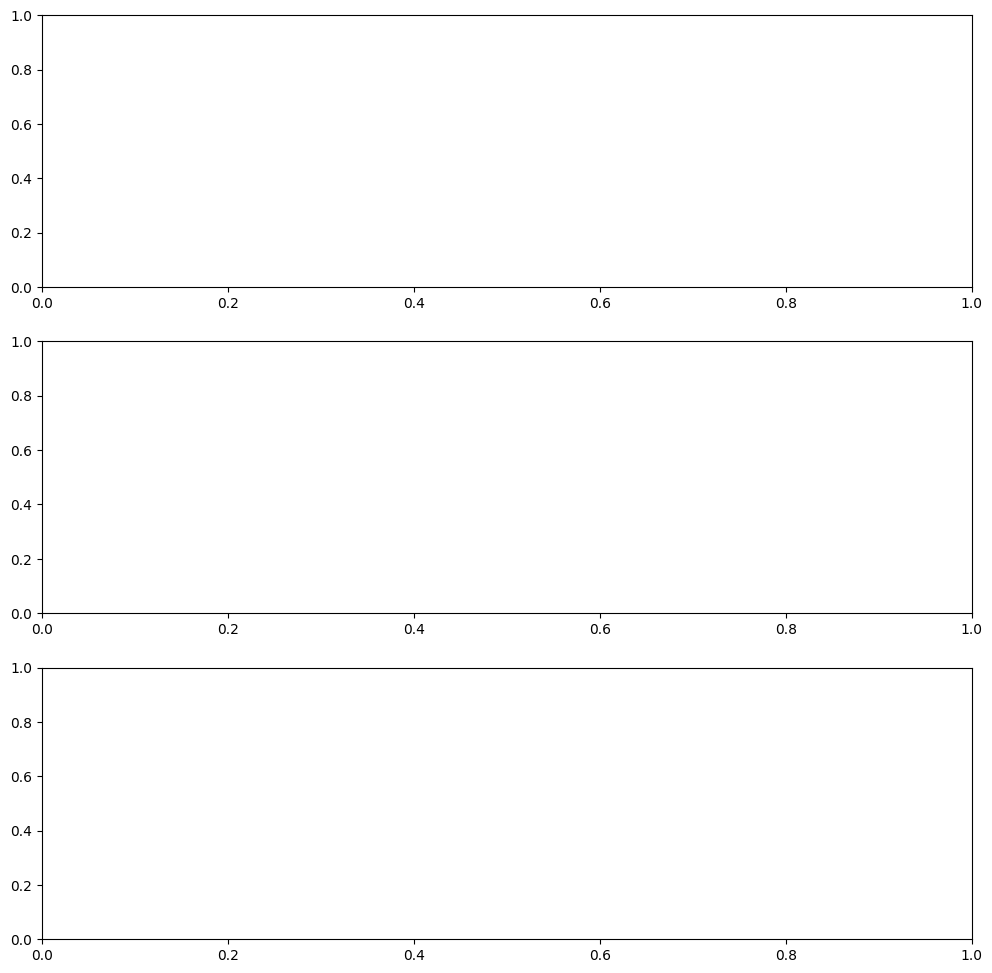

In [13]:
# Plot loss history of models
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

bitcoin_history = bitcoin_pipeline.get_history()
ethereum_history = ethereum_pipeline.get_history()
litecoin_history = litecoin_pipeline.get_history()

ax[0].plot(bitcoin_history['loss'], label='Train Loss')
ax[0].plot(bitcoin_history['val_loss'], label='Validation Loss')
ax[0].set_title('Bitcoin Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(ethereum_history['loss'], label='Train Loss')
ax[1].plot(ethereum_history['val_loss'], label='Validation Loss')
ax[1].set_title('Ethereum Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(litecoin_history['loss'], label='Train Loss')
ax[2].plot(litecoin_history['val_loss'], label='Validation Loss')
ax[2].set_title('Litecoin Model Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

plt.tight_layout()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


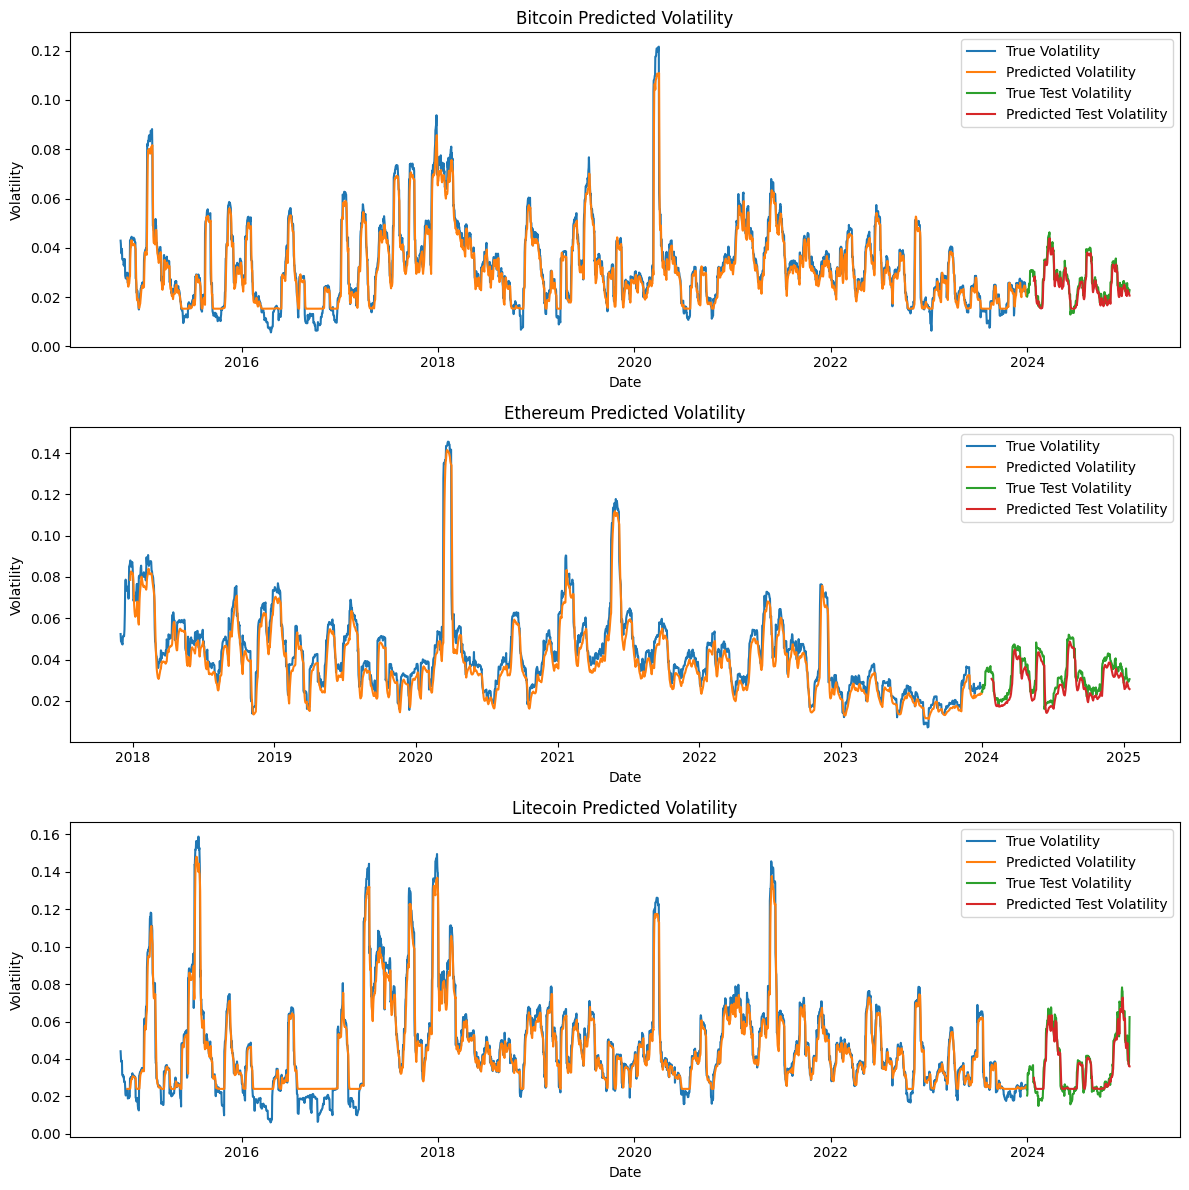

In [ ]:
def predict_and_plot(pipeline, train_data, test_data, ax, title):
    y_pred_train = pipeline.predict(train_data[["Volatility"]].values)
    y_pred_test = pipeline.predict(test_data[["Volatility"]].values)
    
    ax.plot(train_data["Date"], train_data["Volatility"], label="True Volatility")
    ax.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Volatility")
    ax.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility")
    ax.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return y_pred_train, y_pred_test

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

y_pred_bitcoin_train, y_pred_bitcoin_test = predict_and_plot(bitcoin_pipeline, bitcoin_train_data, bitcoin_test_data, ax[0], "Bitcoin Predicted Volatility")
y_pred_ethereum_train, y_pred_ethereum_test = predict_and_plot(ethereum_pipeline, ethereum_train_data, ethereum_test_data, ax[1], "Ethereum Predicted Volatility")
y_pred_litecoin_train, y_pred_litecoin_test = predict_and_plot(litecoin_pipeline, litecoin_train_data, litecoin_test_data, ax[2], "Litecoin Predicted Volatility")

plt.tight_layout()
plt.show()

# Risk-Parity Portfolio

In [14]:
def compute_weights(volatility_time_series):
    inverse_volatility = 1 / volatility_time_series
    weights = inverse_volatility.div(inverse_volatility.sum(axis=1), axis=0)
    assert np.allclose(weights.sum(axis=1), 1), "Weights do not sum to 1 for each time period."
    return weights.values

In [15]:
import pandas as pd
y_pred_all_currency = pd.DataFrame({"bitcoin": y_pred_bitcoin_test.flatten(), "ethereum": y_pred_ethereum_test.flatten(), "litecoin": y_pred_litecoin_test.flatten()})
weights = compute_weights(y_pred_all_currency)

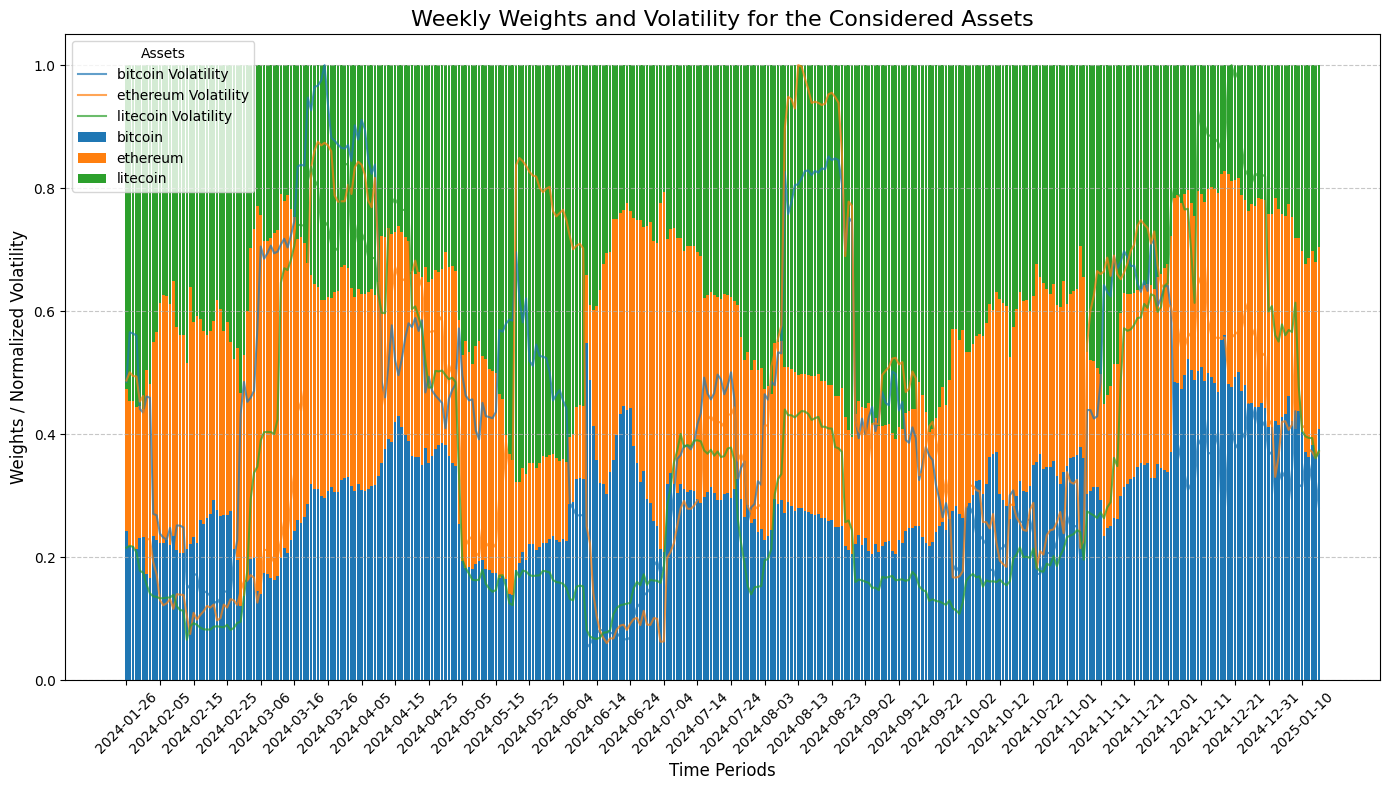

In [16]:
# Conversion en DataFrame pour faciliter le traçage
weights_df = pd.DataFrame(weights, columns=y_pred_all_currency.columns)

# Création du graphique
plt.figure(figsize=(14, 8))

# Tracer chaque colonne comme une barre empilée
bottom_values = np.zeros(len(weights))  # Initialisation des bases pour les barres empilées
for column in weights_df.columns:
    plt.bar(weights_df.index, weights_df[column], bottom=bottom_values, label=column)
    bottom_values += weights_df[column]

# Ajouter une ligne pour chaque série temporelle de volatilité
for column in y_pred_all_currency.columns:
    plt.plot(y_pred_all_currency.index, 
             y_pred_all_currency[column] / y_pred_all_currency[column].max(), linestyle='-', label=f"{column} Volatility", alpha=0.7)

# Configuration du graphique
plt.title("Weekly Weights and Volatility for the Considered Assets", fontsize=16)
plt.xlabel("Time Periods", fontsize=12)
plt.ylabel("Weights / Normalized Volatility", fontsize=12)
plt.legend(title="Assets", fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(weights_df.index[::10], bitcoin_data["Date"][-len(weights_df):].dt.strftime('%Y-%m-%d').tolist()[::10], rotation=45)
# Afficher le graphique
plt.tight_layout()
plt.show()
# Add date labels to the x-axis

# Calcul des rendements

In [17]:
bitcoin_log_returns = bitcoin_test_data["Log Returns"][-len(weights_df):].values
eth_log_returns = ethereum_test_data["Log Returns"][-len(weights_df):].values
ltc_log_returns = litecoin_test_data["Log Returns"][-len(weights_df):].values

# Rendements du portefeuille
log_returns_matrix = np.array([bitcoin_log_returns, eth_log_returns, ltc_log_returns]).T
portfolio_returns = np.sum(weights * log_returns_matrix, axis=1)

# Rendements du portefeuille équilibré
balanced_weights = np.array([1/3, 1/3, 1/3])
balanced_returns = np.sum(balanced_weights * log_returns_matrix, axis=1)

# Rendements cumulés
cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1
cumulative_balanced_return = np.prod(1 + balanced_returns) - 1

# Affichage des résultats
print(f"Rendement cumulé (portefeuille dynamique): {cumulative_portfolio_return:.2%}")
print(f"Rendement cumulé (portefeuille équilibré): {cumulative_balanced_return:.2%}")

Rendement cumulé (portefeuille dynamique): 64.96%
Rendement cumulé (portefeuille équilibré): 57.84%


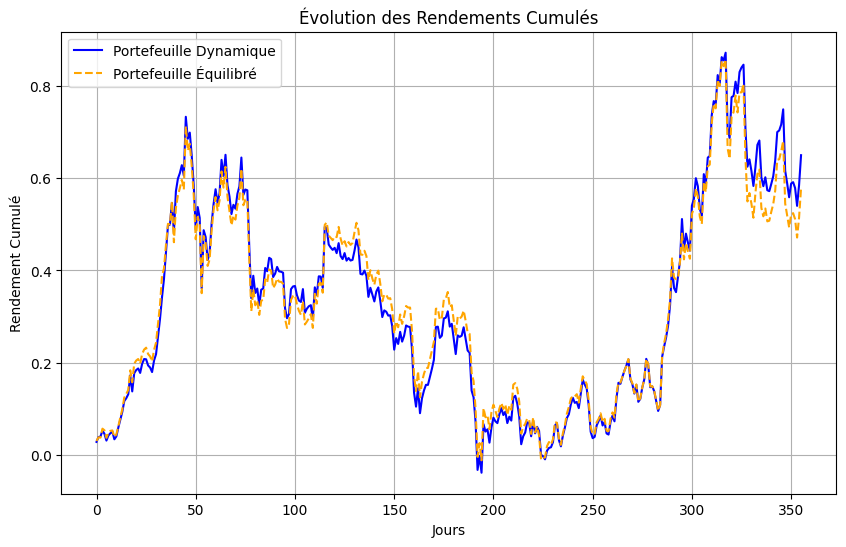

In [18]:
cumulative_portfolio_returns = np.cumprod(1 + portfolio_returns) - 1
cumulative_balanced_returns = np.cumprod(1 + balanced_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns, label="Portefeuille Dynamique", color='blue')
plt.plot(cumulative_balanced_returns, label="Portefeuille Équilibré", color='orange', linestyle='--')
plt.title("Évolution des Rendements Cumulés")
plt.xlabel("Jours")
plt.ylabel("Rendement Cumulé")
plt.legend()
plt.grid(True)
plt.show()